# Vehicle Detection and Tracking

This project consists of detection and tracking vehicles in images and video.
For this, some of the steps are:
- extract image features
- search for cars in images implementing a sliding window algorithm
- train a machine learning classifier (SVM, decision tree, neural network, etc.)
- evaluate the results checking for false positives and false negatives


Features could be:
- raw color intensity (pixel value => Template matching)
- histogram of pixel intensity
- gradients of pixel intensity
- saturation channel (change color spaces)
- histogram of oriented gradients (HOG)

https://en.wikipedia.org/wiki/Feature_vector

In [158]:
import numpy as np
import cv2
import glob
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.figure import Figure
from skimage.feature import hog

#from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import warnings
%matplotlib inline
#%matplotlib qt

In [36]:
def inspect_data(car_list, notcar_list):
    data_dict = {}
    data_dict["n_cars"] = len(car_list)
    data_dict["n_notcars"] = len(notcar_list)
    example = mpimg.imread(car_list[0])
    data_dict["image_shape"] = example.shape
    data_dict["data_type"] = example.dtype
    return data_dict

In [206]:
def convert_color(img, conv='HLS'):
    if conv == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

In [4]:
# draws boxes or circles on image/frame
def draw_emphasis(img, bboxes, color=(0, 0, 255), thick=6, form='box'):
    # make a copy of the image
    draw_img = np.copy(img)
    if form == 'box':
        # draw each bounding box on your image copy using cv2.rectangle()
        for box in bboxes:
            #
            cv2.rectangle(draw_img, box[0], box[1], color, thick)
    elif form == 'circle':
        cv2.circle(draw_img, ((box[0][0] + box[1][0])/2, (box[0][1] + box[1][1])/2), (box[1][0] - box[0][0])/2, color, thick)
    
    # return the image copy with boxes drawn
    return draw_img

In [5]:
#
# https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/fd66c083-4ccb-4fe3-bda1-c29db76f50a0/concepts/9acf11c2-a5a9-4e5a-ba86-1e92246fff99
#
def find_matches(img, template_list):
    # Define an empty list to take bbox coords
    bbox_list = []
    # Define matching method
    # Other options include: cv2.TM_CCORR_NORMED', 'cv2.TM_CCOEFF', 'cv2.TM_CCORR',
    #         'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED'
    method = cv2.TM_CCOEFF_NORMED
    # Iterate through template list
    for temp in template_list:
        # Read in templates one by one
        tmp = mpimg.imread(temp)
        # Use cv2.matchTemplate() to search the image
        result = cv2.matchTemplate(img, tmp, method)
        # Use cv2.minMaxLoc() to extract the location of the best match
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        # Determine a bounding box for the match
        w, h = (tmp.shape[1], tmp.shape[0])
        if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
            top_left = min_loc
        else:
            top_left = max_loc
        bottom_right = (top_left[0] + w, top_left[1] + h)
        # Append bbox position to list
        bbox_list.append((top_left, bottom_right))
    
    # Return the list of bounding boxes
    bbox_list

In [185]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist, bin_edges = np.histogram(img[:,:,0], bins=nbins, range=bins_range, density=True)
    rhist = rhist * np.diff(bin_edges)
    
    ghist, bin_edges = np.histogram(img[:,:,1], bins=nbins, range=bins_range, density=True)
    ghist = ghist * np.diff(bin_edges)
    
    bhist, bin_edges = np.histogram(img[:,:,2], bins=nbins, range=bins_range, density=True)
    bhist = bhist * np.diff(bin_edges)
    
    # Concatenate the histograms into a single feature vector
    #hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    hist_features = np.concatenate((rhist, ghist, bhist))
    
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [228]:
# return a resize image converted to some colorspace as a feature vector
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # 
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(img)      
    
    img = cv2.resize(feature_image, size)
    features = img.ravel().astype(np.float64)  # ravel == reshape
    
    # Return the feature vector
    return features

In [76]:
# apply skimage hog function and returns feature vector
def get_hog_features(img, orient, pix_per_cell, cell_per_block, transform_sqrt=False, vis=False, feature_vec=True):
    features, hog_image = hog(img, 
                              orientations=orient,
                              pixels_per_cell=(pix_per_cell, pix_per_cell),
                              cells_per_block=(cell_per_block, cell_per_block), 
                              transform_sqrt=transform_sqrt, 
                              visualise=True, 
                              feature_vector=feature_vec)
    if vis == True:
        return features, hog_image
    else:      
        return features

In [229]:
# Define a function to extract features from a list of images
# Takes in list of files, convert color, resize, calculate histogram, extract hog, 
# Have this function call bin_spatial() and color_hist()
def extract_train_features(imgs, 
                           cspace='RGB', 
                           orient=9,
                           pix_per_cell=8, 
                           cell_per_block=2, 
                           spatial_size=(32, 32),
                           hist_bins=32, 
                           hist_range=(0, 256), 
                           hog_channel=0):
    
    # Create a list to append feature vectors to
    features = []
    
    # Iterate through the list of images
    i = 0
    for file in imgs:
        i += 1
        
        # Read in each one by one
        image = mpimg.imread(file)
        
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else:
            feature_image = np.copy(image)      
        
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        
        # resize image
        #feature_image = cv2.resize(feature_image, spatial_size)
        
        i_s = image.shape
        # 
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                #imgrs = cv2.resize(feature_image[:, :, channel], (i_s[0]*1, i_s[1]*1))
                imgrs = feature_image[:, :, channel].copy()
                hog_features.append(get_hog_features(imgrs, 
                                                     orient, 
                                                     pix_per_cell, 
                                                     cell_per_block, 
                                                     vis=False, 
                                                     feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:, :, hog_channel], 
                                            orient, 
                                            pix_per_cell, 
                                            cell_per_block, 
                                            vis=False, 
                                            feature_vec=True)


        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))

    a = np.array(spatial_features)
    b = np.array(hist_features)
    c = np.array(hog_features)
    print('   spatial', a.shape, a.dtype)
    print('   histogram', b.shape, b.dtype)
    print('   hog', c.shape, c.dtype)
    
    # Return list of feature vectors
    return features
    #return np.array(features).astype(np.float64) 

In [10]:
def frame_features():
    pass

In [287]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, i, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, cps, spatial_size, window, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop, :, :]
    ctrans_tosearch = convert_color(img_tosearch, conv='YUV')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # color channels
    ch1 = ctrans_tosearch[:, :, 0]
    ch2 = ctrans_tosearch[:, :, 1]
    ch3 = ctrans_tosearch[:, :, 2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient * cell_per_block ** 2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    #window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = cps  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire search region
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    print("="*40)
    print('Find cars: image {:>4d}'.format(i))
    print("="*40)
    print('  pix_per_cell', pix_per_cell)
    print('  cell_per_block', cell_per_block)
    print('  cells_per_step', cells_per_step)
    print('  nxblocks', nxblocks)
    print('  nyblocks', nyblocks)
    print('  nxsteps', nxsteps)
    print('  nysteps', nysteps)
    print('  nblocks_per_window', nblocks_per_window)
    print('  ', 0)
    print('  ', 0)
    print('  ', 0)
    
    boxlist = []
    bbox = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            
            # walk in cells
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            
            # 
            hog_features = np.ravel([hog_feat1, hog_feat2, hog_feat3])

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (64, 64))
            
            #boxlist.append([xleft, ytop, xleft + window, ytop + window])
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            f1 = True if np.isfinite(hog_features).all() else False
            #print('  hog_features', hog_features.shape, hog_features.dtype, f1)
            
            f2 = True if np.isfinite(spatial_features).all() else False
            #print('  spatial_features', spatial_features.shape, spatial_features.dtype, f2)
            
            f3 = True if np.isfinite(hist_features).all() else False
            #print('  hist_features', hist_features.shape, hist_features.dtype, f3)

            # Scale features and make a prediction
            features = np.concatenate((spatial_features, hist_features, hog_features)).reshape(1, -1)
            
            f = True if np.isfinite(features).all() else False
            #print('  features', features.shape, features.dtype, f)
            
            if f and f1 and f2 and f3:
                test_features = X_scaler.transform(features)    
                #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
                test_prediction = svc.predict(test_features)
            else:
                print('  infinity')
                print('  yb', yb, 'xb', xb)
                print('  ypos', ypos, 'xpos', xpos)
                print('  image shape', ctrans_tosearch.shape)
                #plt.figure()
                #plt.imshow(subimg)
                #return draw_img, boxlist, bbox
                test_prediction = 0
            
            
            xbox_left = np.int(xleft * scale)
            ytop_draw = np.int(ytop * scale)
            win_draw = np.int(window * scale)
            p1 = (xbox_left, ytop_draw + ystart)
            p2 = (xbox_left + win_draw, ytop_draw + win_draw + ystart)
            boxlist.append((p1,p2))
            t = 6
            if test_prediction == 1:
                cor = (0, 0, 255)
                cv2.rectangle(draw_img, p1, p2, cor, 3)
                bbox.append((p1,p2))
            else:
                cor = (0, 255, 0)
                cv2.rectangle(draw_img, p1, p2, cor, 3) 
            #cv2.rectangle(draw_img, (xleft, ytop), (xleft + window, ytop + window), (255, 255, 255), 5)
                
    return draw_img, boxlist, bbox

In [ ]:
def find_cars_2():
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255

    # Compute individual channel HOG features for the entire search region
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    windows = slide_window(img, x_start_stop, y_start_stop, xy_window, xy_overlap)
    
    boxes = []
    
    for w in range(0, len(windows)):

        # Extract HOG for this patch
        hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel() 
        hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel() 
        hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()

        # 
        hog_features = np.ravel([hog_feat1, hog_feat2, hog_feat3])

        img_tosearch = img[ystart:ystop, :, :]
        ctrans_tosearch = convert_color(img_tosearch, conv='YUV')

        subimg = cv2.resize(ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (64, 64))

        spatial_features = bin_spatial(subimg, size=spatial_size)
        hist_features = color_hist(subimg, nbins=hist_bins)

        f1 = True if np.isfinite(hog_features).all() else False
        #print('  hog_features', hog_features.shape, hog_features.dtype, f1)

        f2 = True if np.isfinite(spatial_features).all() else False
        #print('  spatial_features', spatial_features.shape, spatial_features.dtype, f2)

        f3 = True if np.isfinite(hist_features).all() else False
        #print('  hist_features', hist_features.shape, hist_features.dtype, f3)

        # Scale features and make a prediction
        features = np.concatenate((spatial_features, hist_features, hog_features)).reshape(1, -1)

        f = True if np.isfinite(features).all() else False
        #print('  features', features.shape, features.dtype, f)

        if f and f1 and f2 and f3:
            test_features = X_scaler.transform(features)    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
        
        xbox_left = np.int(xleft * scale)
        ytop_draw = np.int(ytop * scale)
        win_draw = np.int(window * scale)
        p1 = (xbox_left, ytop_draw + ystart)
        p2 = (xbox_left + win_draw, ytop_draw + win_draw + ystart)
        boxlist.append((p1,p2))
        t = 6
        if test_prediction == 1:
            #cor = (0, 0, 255)
            #cv2.rectangle(draw_img, p1, p2, cor, 3)
            boxes.append((p1,p2))

    return boxes

In [12]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, 
                 x_start_stop=[None, None], 
                 y_start_stop=[None, None], 
                 xy_window=(64, 64), 
                 xy_overlap=(0.5, 0.5)):
    
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    
    # Return the list of windows
    return window_list

In [291]:
#heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_boxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
#heat = add_heat(heat,box_list)
# Apply threshold to help remove false positives
#heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
#heatmap = np.clip(heat, 0, 255)
#labels = label(heatmap)

In [15]:
# numpy
# np.ravel = np.reshape(-1)
# https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ravel.html
# 

# CV2
# https://docs.opencv.org/trunk/d4/dc6/tutorial_py_template_matching.html
# 

# scikit-image
# http://scikit-image.org/docs/dev/api/skimage.feature.html?highlight=feature%20hog#skimage.feature.hog
# 

# scikit-learn
# http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV


In [18]:
from car_search import Car

In [19]:
car = Car()

# Process images

## HOG features

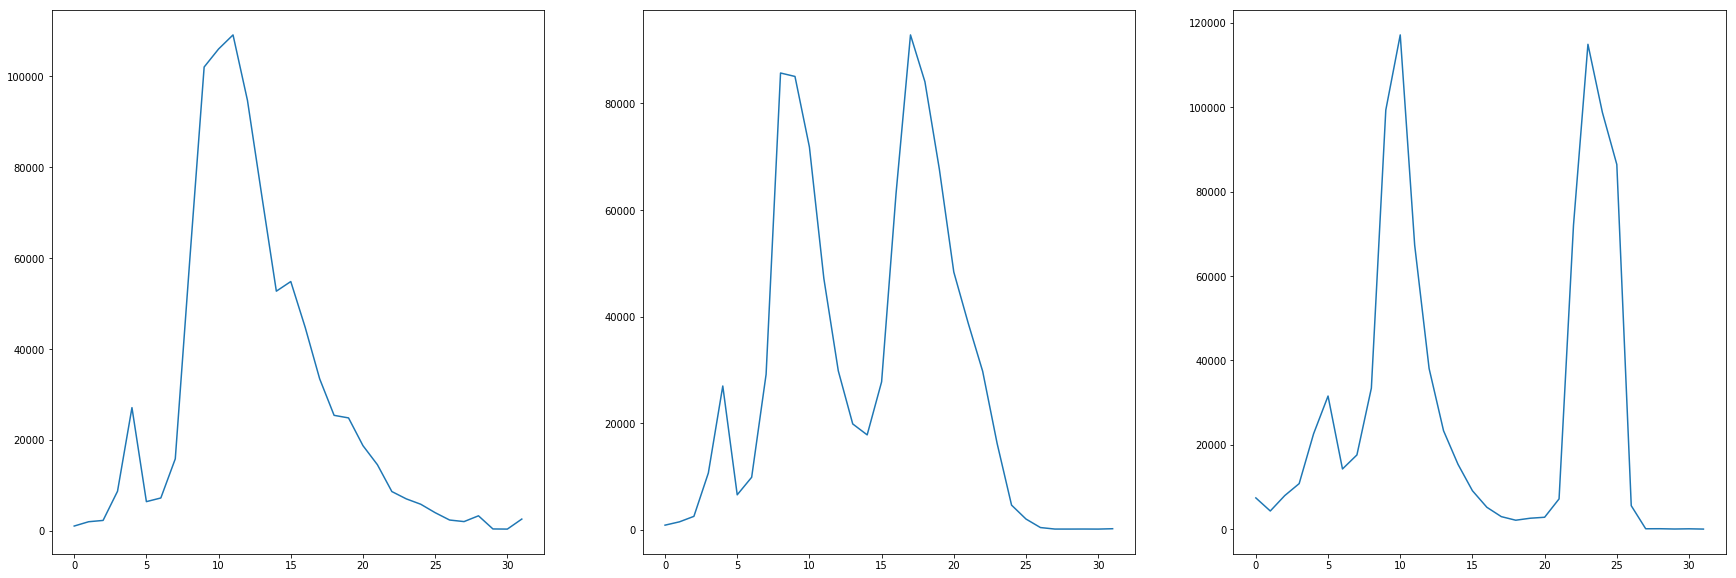

In [20]:
filen = str(np.random.randint(1, 6))
img = mpimg.imread('./test_images/test' + filen + '.jpg')

rhist, ghist, bhist, bin_centers, hist_features = color_hist(img, nbins=32, bins_range=(0, 256))

plt.figure()
fig, axs = plt.subplots(1, 3, figsize=(30, 10))
#rint(rhist)
axs[0].plot(rhist[0])
axs[1].plot(ghist[0])
axs[2].plot(bhist[0])

Image examples:


(-0.5, 63.5, 63.5, -0.5)

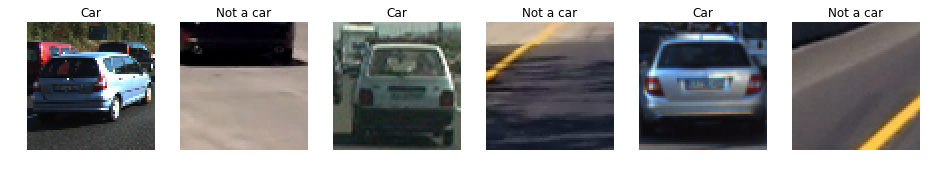

In [75]:
notcarsfiles = glob.glob('non-vehicles/*/*.png')
carsfiles = glob.glob('vehicles/*/*.png')

rand_carnot = np.random.randint(0, len(notcarsfiles))
rand_caryes = np.random.randint(0, len(carsfiles))

example_car = mpimg.imread(cars[rand_caryes])
example_not = mpimg.imread(notcars[rand_carnot])

print('Image examples:')

f = plt.figure();
#plt.axis('off')
fig, axs = plt.subplots(1, 6, figsize=(16, 8));
axs[0].imshow(example_car);
axs[0].set_title('Car');
axs[0].axis('off')
axs[1].imshow(example_not);
axs[1].set_title('Not a car');
axs[1].axis('off')

rand_carnot = np.random.randint(0, len(notcarsfiles))
rand_caryes = np.random.randint(0, len(carsfiles))

example_car = mpimg.imread(cars[rand_caryes])
example_not = mpimg.imread(notcars[rand_carnot])

axs[2].imshow(example_car);
axs[2].set_title('Car');
axs[2].axis('off')
axs[3].imshow(example_not);
axs[3].set_title('Not a car');
axs[3].axis('off')

rand_carnot = np.random.randint(0, len(notcarsfiles))
rand_caryes = np.random.randint(0, len(carsfiles))

example_car = mpimg.imread(cars[rand_caryes])
example_not = mpimg.imread(notcars[rand_carnot])

axs[4].imshow(example_car);
axs[4].set_title('Car');
axs[4].axis('off')
axs[5].imshow(example_not);
axs[5].set_title('Not a car');
axs[5].axis('off')

In [42]:
datainsp = inspect_data(carsfiles, notcarsfiles)
for (k, d) in datainsp.items():
    print(k, d)

n_cars 8792
n_notcars 8968
image_shape (64, 64, 3)
data_type float32


In [63]:
# not cars has more samples
diff = datainsp['n_notcars'] - datainsp['n_cars']
print('Difference in length:', diff)

carlist = np.array(carsfiles)
notcarlist = np.array(notcarsfiles)

diffrandidx = np.array(np.random.randint(0, datainsp['n_cars'], size=diff), np.int)

print('Random indexes')
print(diffrandidx)
#print(carlist[diffrandidx])

# duplicate 'diff' cars
carlist = np.concatenate((carlist, carlist[diffrandidx]))
print('New length: ', len(carlist))

176
[4396 4528 5403 4701 6646 3618 8657 4870 6259 2768 4449 3260 5058 4067 2701
 2497 7037 4436 2438 3295 2975 4317 6651 7599 7728 3726 7749 6487 3583 4637
 4072 4983 8211 1306 4254 1411 3597  962 1182 7270 4749 6381 2023 3116 3215
 2185 1767 8537 6280 4678  830 7652  165 6405 5824 7036 2312 5560 7608 8280
 3825 6168 8109 2321 5260 1588 8511 3258 1329 7681  242 8059 4963 4668 6547
 7541 2964 3363  584 5290 2369 2034 1275 6452 8538 3584 2848 7791  241 8730
 1666 6956 7676 1843 7015 3213 5259 5585 4571 6085 2416 2971 3945 6522 4403
 7148 3954 5884 3601 2086 6687 1875 1786 3335 2655 5500 1946 7791 2504 4411
 6874 8505 1330 2524 5558 5492 1018 5764 4336 2116 6083  862 6844 1532   59
 1199 2043 4375 7795 8284 7829 4229 4385 7714 7557 5833 2424 7879 8473 4806
 7097 3380 4596 2496 8215 8469  221 8196 3870 4185 2421 1001 4262  770 3530
  360 7273 6517 1333 5710 8037 4572 3403 1118 3907 1218]
New length:  8968


Text(0.5,1,'HOG for V channel in YUV')

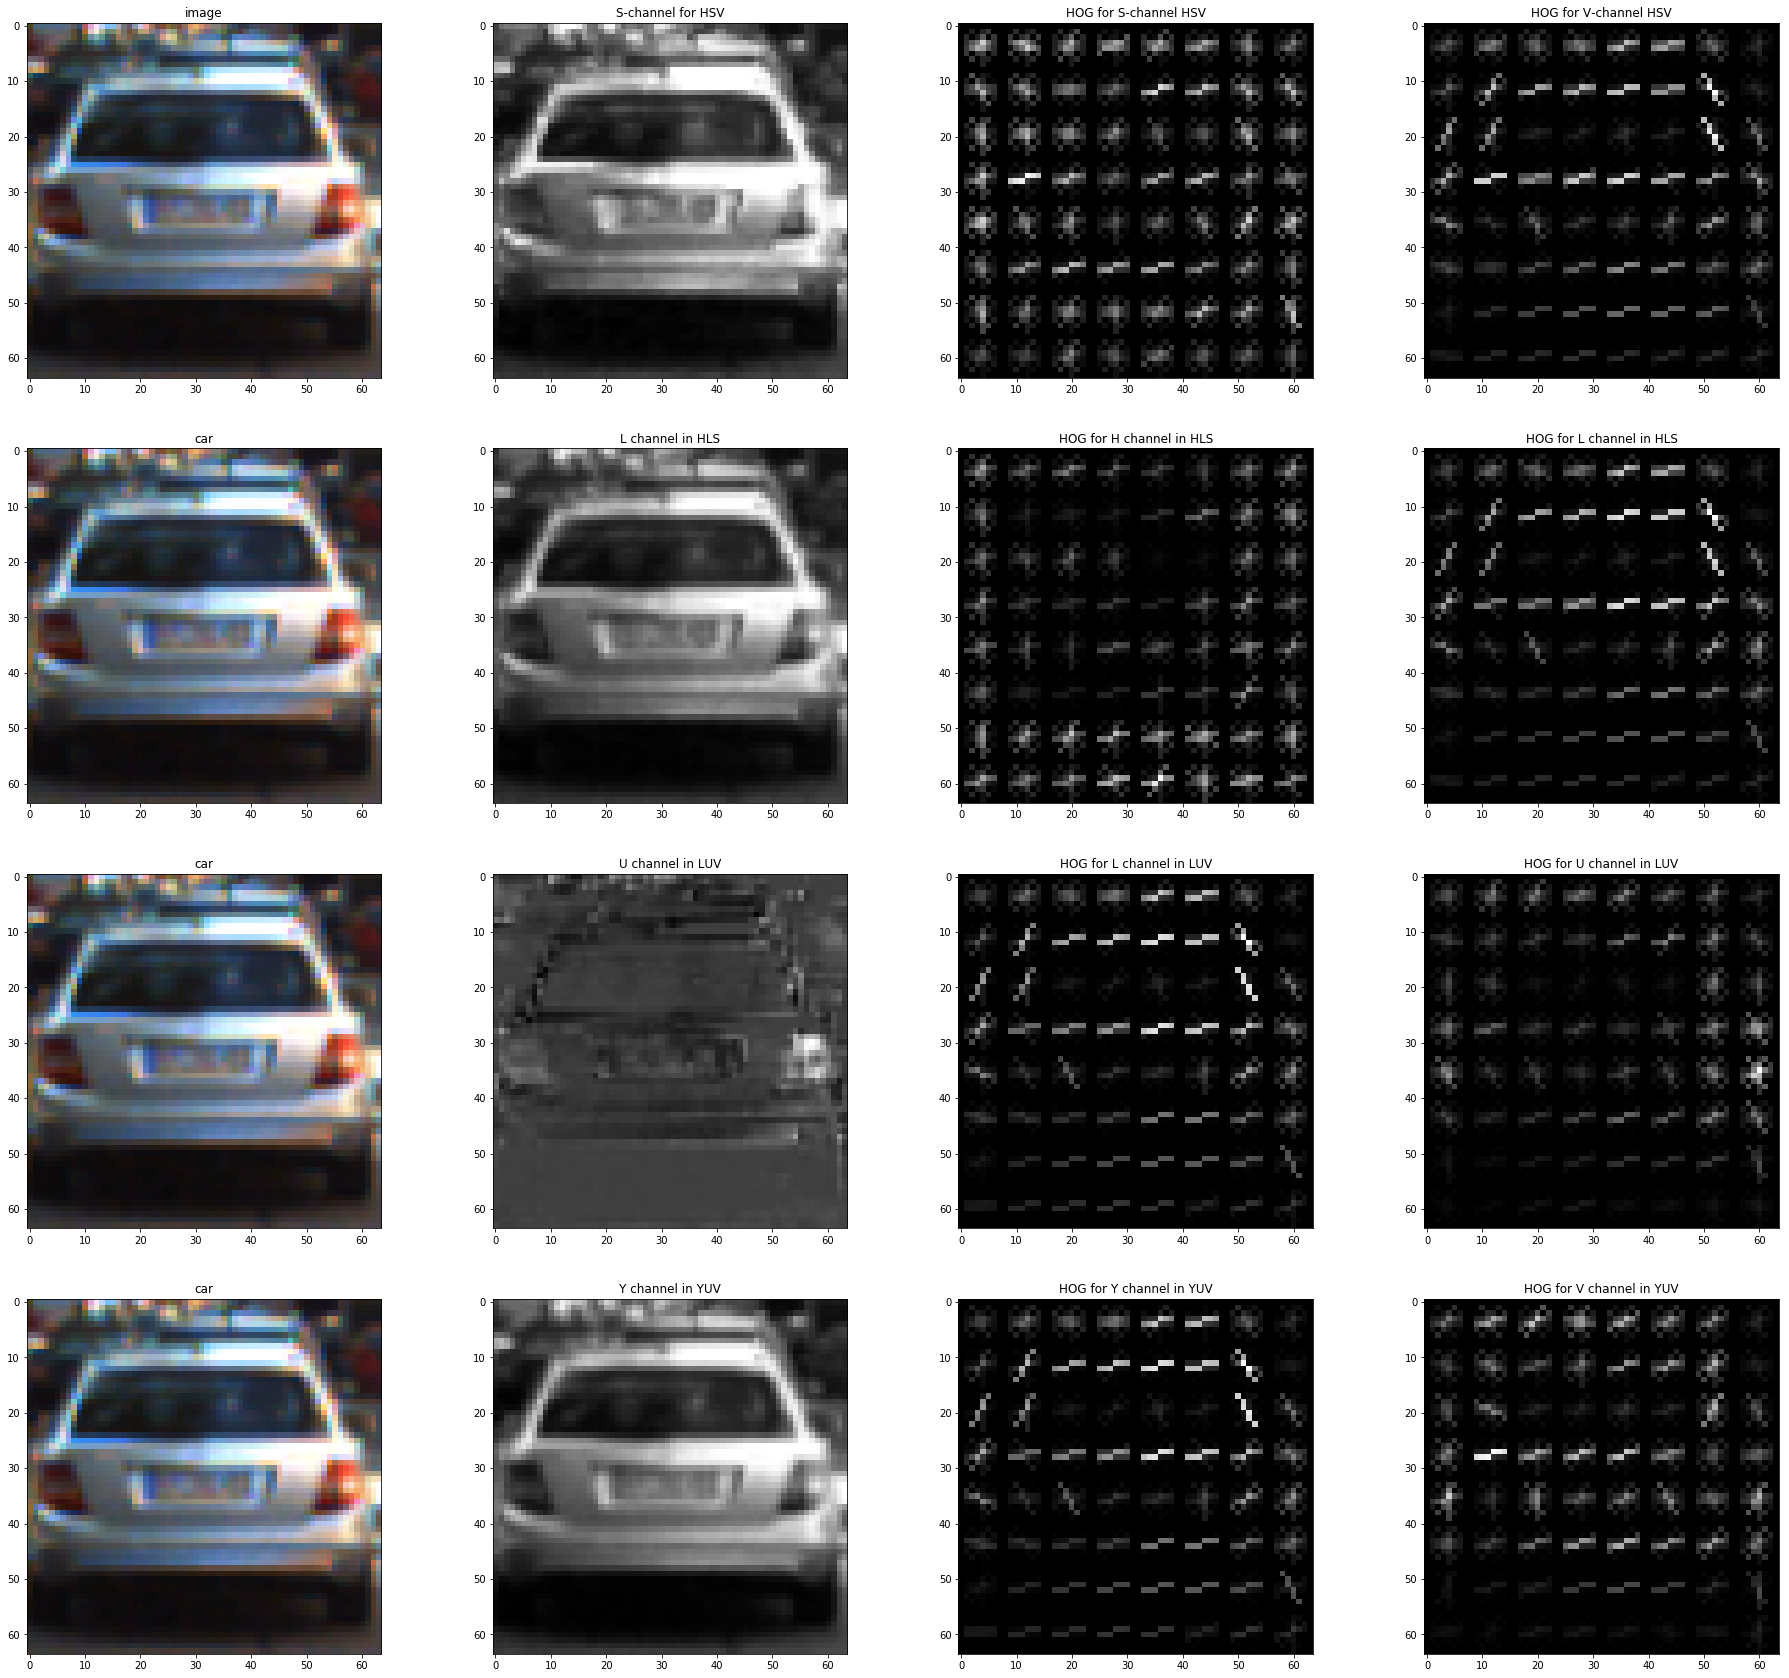

In [95]:
rand_carnot = np.random.randint(0, len(notcarsfiles))
rand_caryes = np.random.randint(0, len(carsfiles))

# orientation
o = 9
# pix per cell
ppc = 8
# cell per block
cpb = 2

example_car_1 = mpimg.imread(cars[rand_caryes])
example_not_1 = mpimg.imread(notcars[rand_carnot])

image_1_1 = cv2.cvtColor(example_car_1, cv2.COLOR_RGB2HSV)
image_1_2 = cv2.cvtColor(example_car_1, cv2.COLOR_RGB2HLS)
image_1_3 = cv2.cvtColor(example_car_1, cv2.COLOR_RGB2LUV)
image_1_4 = cv2.cvtColor(example_car_1, cv2.COLOR_RGB2YUV)
#image = cv2.cvtColor(example_car_1, cv2.COLOR_RGB2YCrCb)

_, hog_image_1_1_0 = get_hog_features(image_1_1[:, :, 0], o, ppc, cpb, vis=True, feature_vec=False)
_, hog_image_1_1_1 = get_hog_features(image_1_1[:, :, 1], o, ppc, cpb, vis=True, feature_vec=False)
_, hog_image_1_1_2 = get_hog_features(image_1_1[:, :, 2], o, ppc, cpb, vis=True, feature_vec=False)

_, hog_image_1_2_0 = get_hog_features(image_1_2[:, :, 0], o, ppc, cpb, vis=True, feature_vec=False)
_, hog_image_1_2_1 = get_hog_features(image_1_2[:, :, 1], o, ppc, cpb, vis=True, feature_vec=False)
_, hog_image_1_2_2 = get_hog_features(image_1_2[:, :, 2], o, ppc, cpb, vis=True, feature_vec=False)

_, hog_image_1_3_0 = get_hog_features(image_1_3[:, :, 0], o, ppc, cpb, vis=True, feature_vec=False)
_, hog_image_1_3_1 = get_hog_features(image_1_3[:, :, 1], o, ppc, cpb, vis=True, feature_vec=False)
_, hog_image_1_3_2 = get_hog_features(image_1_3[:, :, 2], o, ppc, cpb, vis=True, feature_vec=False)

_, hog_image_1_4_0 = get_hog_features(image_1_4[:, :, 0], o, ppc, cpb, vis=True, feature_vec=False)
_, hog_image_1_4_1 = get_hog_features(image_1_4[:, :, 1], o, ppc, cpb, vis=True, feature_vec=False)
_, hog_image_1_4_2 = get_hog_features(image_1_4[:, :, 2], o, ppc, cpb, vis=True, feature_vec=False)



plt.figure(figsize=(32, 30))
#plt.axes('off')
plt.subplot(4, 4, 1)
plt.imshow(example_car_1)
plt.title('image')
plt.subplot(4, 4, 2)
plt.imshow(image_1_1[:, :, 2], cmap='gray')
plt.title('S-channel for HSV')
plt.subplot(4, 4, 3)
plt.imshow(hog_image_1_1_1, cmap='gray')
plt.title('HOG for S-channel HSV')
plt.subplot(4, 4, 4)
plt.imshow(hog_image_1_1_2, cmap='gray')
plt.title('HOG for V-channel HSV')


plt.subplot(4, 4, 5)
plt.imshow(example_car_1, cmap='gray')
plt.title('car')
plt.subplot(4, 4, 6)
plt.imshow(image_1_2[:, :, 1], cmap='gray')
plt.title('L channel in HLS')
plt.subplot(4, 4, 7)
plt.imshow(hog_image_1_2_0, cmap='gray')
plt.title('HOG for H channel in HLS')
plt.subplot(4, 4, 8)
plt.imshow(hog_image_1_2_1, cmap='gray')
plt.title('HOG for L channel in HLS')


plt.subplot(4, 4, 9)
plt.imshow(example_car_1, cmap='gray')
plt.title('car')
plt.subplot(4, 4, 10)
plt.imshow(image_1_3[:, :, 1], cmap='gray')
plt.title('U channel in LUV')
plt.subplot(4, 4, 11)
plt.imshow(hog_image_1_3_0, cmap='gray')
plt.title('HOG for L channel in LUV')
plt.subplot(4, 4, 12)
plt.imshow(hog_image_1_3_1, cmap='gray')
plt.title('HOG for U channel in LUV')

plt.subplot(4, 4, 13)
plt.imshow(example_car_1, cmap='gray')
plt.title('car')
plt.subplot(4, 4, 14)
plt.imshow(image_1_3[:, :, 0], cmap='gray')
plt.title('Y channel in YUV')
plt.subplot(4, 4, 15)
plt.imshow(hog_image_1_3_0, cmap='gray')
plt.title('HOG for Y channel in YUV')
plt.subplot(4, 4, 16)
plt.imshow(hog_image_1_3_2, cmap='gray')
plt.title('HOG for V channel in YUV')


Model training

Extracting features ...
   spatial (768,) float32
   histogram (96,) float64
   hog (5292,) float64
   spatial (768,) float32
   histogram (96,) float64
   hog (5292,) float64
Time to extract features:  0.45s

car     (5, 6156)
not car (5, 6156)

X (10, 6156) float64
y (10, 1) float64

Training set:
X_train: (8, 6156)
y_train: (8, 1)

Testing set:
X_test: (2, 6156)
y_test: (2, 1)

Time to train SVC:  0.00s
Test Accuracy of SVC:   1.000
(6156,)


Text(0.5,0,'features')

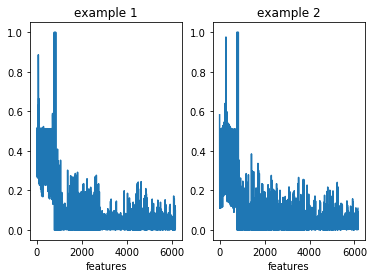

In [210]:
# orientation
o = 9
# pix per cell
ppc = 8
# cell per block
cpb = 2
# color space
cs = 'YUV'
# HOG channels
hogc = '0'
hogc = 'ALL'
# spatial size
ss = (16, 16)
# histogram bins
nhb = 32

# y-region to seach
y_start_stop = [None, None]

print('='*40)
print('Model training')
print('='*40)
print('')

print('Extracting features ...')
t = time.time()

# reduce time during experimentation
sample_size = 5

car_features = extract_train_features(carlist[:sample_size], 
                                      cspace=cs,
                                      spatial_size=ss,
                                      hist_bins=nhb, 
                                      orient=o, 
                                      pix_per_cell=ppc,
                                      cell_per_block=cpb, 
                                      hog_channel=hogc)

notcar_features = extract_train_features(notcarlist[:sample_size], 
                                         cspace=cs,
                                         spatial_size=ss,
                                         hist_bins=nhb, 
                                         orient=o, 
                                         pix_per_cell=ppc,
                                         cell_per_block=cpb, 
                                         hog_channel=hogc)

t2 = time.time()
print('Time to extract features: {:5.2f}s'.format((t2 - t)))
print('')

print('car    ', np.array(car_features).shape)
print('not car', np.array(notcar_features).shape)
print('')

# scaler works better in 64bit
X = np.concatenate((car_features, notcar_features), axis=0).astype(np.float64)  

# labels
y = np.concatenate((np.ones((len(car_features), 1)), np.zeros((len(notcar_features), 1))), axis=0)

print('X', X.shape, X.dtype)
print('y', y.shape, y.dtype)
print('')

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)


# split data set
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.15)

# shuffle data
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)

print('Training set:')
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('')
print('Testing set:')
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)
print('')

# create model object
svc = LinearSVC()

# Check the training time for the SVC
t = time.time()

# =======================
# Fit model
# =======================
svc.fit(X_train, y_train)

t2 = time.time()
print('Time to train SVC: {:5.2f}s'.format((t2 - t)))
      
# Check the score of the SVC
print('Test Accuracy of SVC: {:7.3f}'.format(svc.score(X_test, y_test)))

print(car_features[0].shape)
plt.figure()
plt.subplot(121)
plt.plot(car_features[0])
plt.title('example 1')
plt.xlabel('features')
plt.subplot(122)
plt.plot(car_features[1])
plt.title('example 2')
plt.xlabel('features')

#plt.figure(figsize=(20, 10))
#plt.subplot(131)
#plt.plot(car_features[0][:768])
#plt.subplot(132)
#plt.plot(car_features[0][768:768+96])
#plt.subplot(133)
#plt.plot(car_features[0][768+96:])

In [283]:
img_test_list = glob.glob('test_images/*.jpg')

ex1 = mpimg.imread(img_test_list[0])
print('image shape', ex1.shape)
ystart = np.int(ex1.shape[0] * 0.55)
ystop  = np.int(ex1.shape[0] * 0.92)
ystart = 400
ystop = 656
scale = 1.5

print('serch region in y:', ystart, ystop)

image shape (720, 1280, 3)
serch region in y: 400 656


  'be changed to `L2-Hys` in v0.15', skimage_deprecation)



image 1 test_images/test1.jpg
Find cars: image    1
  pix_per_cell 8
  cell_per_block 2
  cells_per_step 2
  nxblocks 105
  nyblocks 20
  nxsteps 49
  nysteps 6
  nblocks_per_window 7
   0
   0
   0


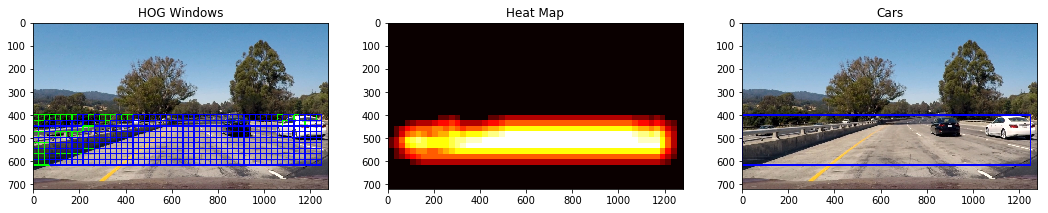

In [292]:
i = 0
#for img_file in img_test_list:
for img_file in ['test_images/test1.jpg']:
    i += 1
    
    print('image', i, img_file)
    
    # read
    img = mpimg.imread(img_file)
    
    # search and find!
    ok = True
    try:
        out_img, all_box, box_list = find_cars(img, 
                                  i,
                                  ystart, 
                                  ystop, 
                                  scale, 
                                  svc, 
                                  X_scaler, 
                                  o, 
                                  ppc, 
                                  cpb, 
                                  2,
                                  ss, 
                                  64,
                                  32)

    except NameError as e:
        print('trouble in image', i)
        ok = False
        print(e)
        continue
    
    heat = np.zeros_like(img[:, :, 0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat, box_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_boxes(np.copy(img), labels)
    
    #draw_emphasis(out_img, box_list, color=(0, 0, 255), thick=6, form='box')
    
    plt.figure(figsize=(18,8))
    
    plt.subplot(131)
    plt.imshow(out_img)
    plt.title('HOG Windows')
    
    plt.subplot(132)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    
    plt.subplot(133)
    plt.imshow(draw_img)
    plt.title('Cars found')
    fig.tight_layout()

In [ ]:
# Read in car and non-car images
images = glob.glob('*.jpeg')
cars = []
notcars = []
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)

# TODO play with these values to see how your classifier
# performs under different binning scenarios
spatial = 32
histbin = 32

car_features = extract_features(cars, cspace='RGB', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))
notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))



feature_list = [feature_vec1, feature_vec2, ...]
# Create an array stack, NOTE: StandardScaler() expects np.float64
X = np.vstack(feature_list).astype(np.float64)
X = np.vstack((car_features, notcar_features)).astype(np.float64)

X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

svc = LinearSVC()
# Train the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()

print('Test Accuracy of SVC = ', svc.score(X_test, y_test))


# Process Video